In [3]:
from __future__ import division

from models import *
from utils.utils import *
from utils.datasets import *
from utils.augmentations import *
from utils.transforms import *

import os
import sys
import time
import datetime
import argparse

from PIL import Image

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Darknet("config/yolov3.cfg", img_size=416).to(device)
model.load_darknet_weights("weights/yolov3.weights")


In [34]:
dataloader = DataLoader(
        ImageFolder("data/samples", transform= \
            transforms.Compose([DEFAULT_TRANSFORMS, Resize(416)])),
        batch_size=1,
        shuffle=True,
        num_workers=12,
    )

In [10]:
classes = load_classes("data/coco.names")  # Extracts class labels from file

In [11]:
model.eval() 

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [12]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

(0) Image: 'data/samples/room.jpg'
	+ Label: chair, Conf: 0.99906
	+ Label: chair, Conf: 0.96942
	+ Label: clock, Conf: 0.99971


<Figure size 432x288 with 0 Axes>

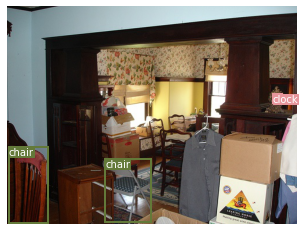

In [44]:
imgs = []  # Stores image paths
img_detections = []  # Stores detections for each image index


batch_i =next(iter(dataloader))

img_paths, input_imgs = batch_i

# Configure input
input_imgs = Variable(input_imgs.type(Tensor))

# Get detections
with torch.no_grad():
    detections = model(input_imgs)
    detections = non_max_suppression(detections, 0.8, 0.4)#confidence thresh iou threshold


# Save image and detections
imgs.extend(img_paths)
img_detections.extend(detections)
# Bounding-box colors
cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

for img_i, (path, detections) in enumerate(zip(imgs, img_detections)):

        print("(%d) Image: '%s'" % (img_i, path))

        # Create plot
        img = np.array(Image.open(path))
        plt.figure()
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        # Draw bounding boxes and labels of detections
        if detections is not None:
            # Rescale boxes to original image
            detections = rescale_boxes(detections, 416, img.shape[:2])
            unique_labels = detections[:, -1].cpu().unique()
            n_cls_preds = len(unique_labels)
            bbox_colors = random.sample(colors, n_cls_preds)
            for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:

                print("\t+ Label: %s, Conf: %.5f" % (classes[int(cls_pred)], cls_conf.item()))

                box_w = x2 - x1
                box_h = y2 - y1

                color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
                # Create a Rectangle patch
                bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
                # Add the bbox to the plot
                ax.add_patch(bbox)
                # Add label
                plt.text(
                    x1,
                    y1,
                    s=classes[int(cls_pred)],
                    color="white",
                    verticalalignment="top",
                    bbox={"color": color, "pad": 0},
                )

        # Save generated image with detections
        plt.axis("off")
        plt.gca().xaxis.set_major_locator(NullLocator())
        plt.gca().yaxis.set_major_locator(NullLocator())
        plt.show()